# Predicting House Value in Boston

>#### STAT 301 Group Project Proposal

>#### Authors: Peter Lee, Hrithik Soni, Tanay Kumar, Jonathan Tuazon

## 1. Introduction

* The main goal of our project is prediction. 
* In this project, we will be looking at the Boston Housing dataset which provides information about houses in Boston such as house value, number of rooms, etc.
* We will use many explanatory variables that describe each house and explore different models to find the model that best predicts the house value ($).

Change made here


#### 1.1. Research Question

* What is the median value (USD) of a house in Boston?

#### 1.2. Response Variable

* **MEEDV**: Median value of a house in Boston (in 1000$)

#### 1.3. Explanatory Variables

* **CRIM**: Per capita crime rate by town
* **ZN**: Proportion of residential land zoned for lots over 25,000 sq. ft
* **INDUS**: Proportion of non-retail business acres per town
* **NOX**: Nitric oxide concentration (parts per 10 million)
* **RM**: Average number of rooms per dwelling
* **AGE**: Proportion of owner-occupied units built prior to 1940
* **DIS**: Weighted distances to five Boston employment centers
* **RAD**: Index of accessibility to radial highways
* **TAX**: Full-value property tax rate per $10,000
* **B**: 1000(Bk - 0.63)², where Bk is the proportion of [people of African American descent] by town
* **LSTAT**: Percentage of lower status of the population

## 2. Exploratory Data Analysis

#### 2.1. Loading Packages

In [2]:
options(repr.plot.width=8, repr.plot.height=6)
library(broom)
library(tidyverse)
library(infer)
library(repr)
library(digest)
library(gridExtra)
library(faraway)
library(mltools)
library(leaps)
library(glmnet)
library(cowplot)
library(AER)
library(GGally)

#### 2.2 Reading the Data

In [3]:
boston_data <-read_tsv("dataset.txt",
                      col_names=FALSE) %>%
    separate(col=X1,
             into=c("CRIM","ZN","INDUS","CHAS","NOX","RM","AGE","DIS","RAD","TAX","PTRATIO","LSTAT","MEEDV"),
             sep="  ") %>%
    separate(col=PTRATIO,
             into=c("PTRATIO","B"),
             sep=" ") %>%
    mutate_if(is.character,as.numeric) 
head(boston_data)

Rows: 506 Columns: 1
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): X1

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“Expected 13 pieces. Additional pieces discarded in 24 rows [103, 156, 157, 417, 420, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 437, 439, 446, 451, 455, ...].”
Warning message:
“Expected 13 pieces. Missing pieces filled with `NA` in 42 rows [9, 24, 32, 58, 142, 143, 144, 146, 147, 152, 159, 160, 210, 259, 260, 352, 353, 354, 355, 356, ...].”
Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 59 rows [9, 24, 32, 103, 142, 143, 144, 146, 147, 152, 156, 157, 210, 368, 374, 375, 380, 383, 384, 387, ...].”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning mess

CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEEDV
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.00632,18,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
0.02731,0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
0.02729,0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
0.03237,0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
0.06905,0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
0.02985,0,2.18,0,0.458,6.430,58.7,6.0622,3,222,18.7,394.12,5.21,28.7


#### 2.3. Correlation Matrix

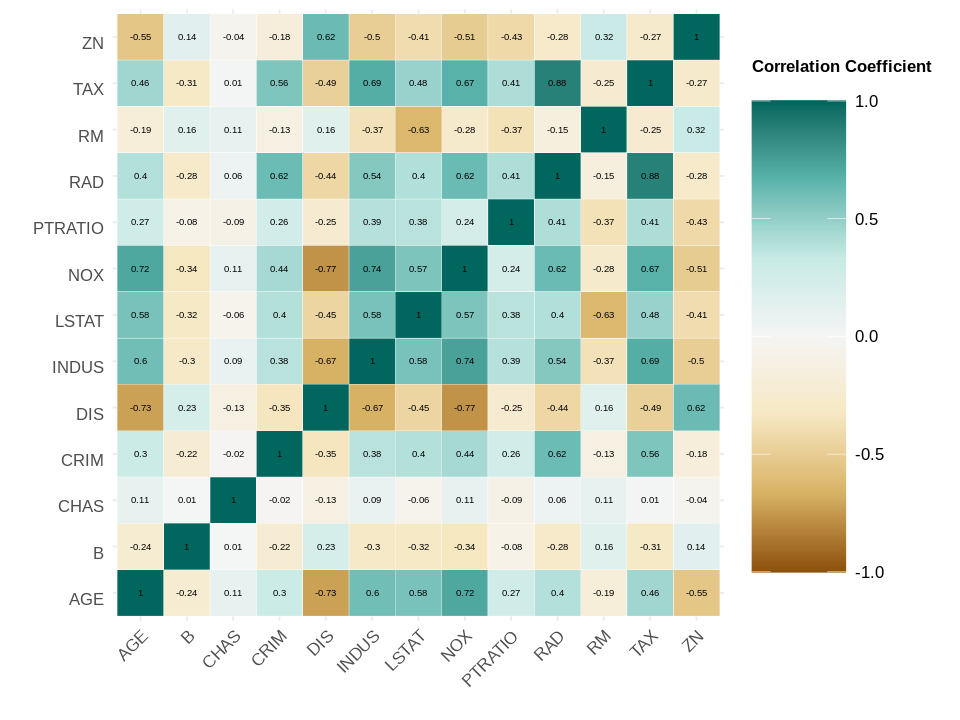

In [4]:
corr_mat <- boston_data %>%
    select(- MEEDV) %>%
    cor(use="complete.obs") %>%
    as.data.frame() %>%
    rownames_to_column("var1") %>%
    pivot_longer(-var1, names_to = "var2", values_to = "corr")

plot_corr_mat <- corr_mat %>%
    ggplot(aes(var1,var2)) +
    geom_tile(aes(fill = corr), color = "white") +
    scale_fill_distiller("Correlation Coefficient \n",
    palette = "BrBG",
    direction = 1, limits = c(-1, 1)
  ) +
  labs(x = "", y = "") +
  theme_minimal() +
  theme(
    axis.text.x = element_text(
      angle = 45, vjust = 1,
      size = 10, hjust = 1
    ),
    axis.text.y = element_text(
      vjust = 1,
      size = 10, hjust = 1
    ),
    legend.title = element_text(size = 10, face = "bold"),
    legend.text = element_text(size = 10),
    legend.key.size = unit(2, "cm")
  ) +
  coord_fixed() +
  geom_text(aes(var2, var1, label = round(corr, 2)), color = "black", size = 2)
plot_corr_mat

#### 2.4. Response Variable Distribution

Warning message:
“Removed 42 rows containing non-finite values (stat_bin).”


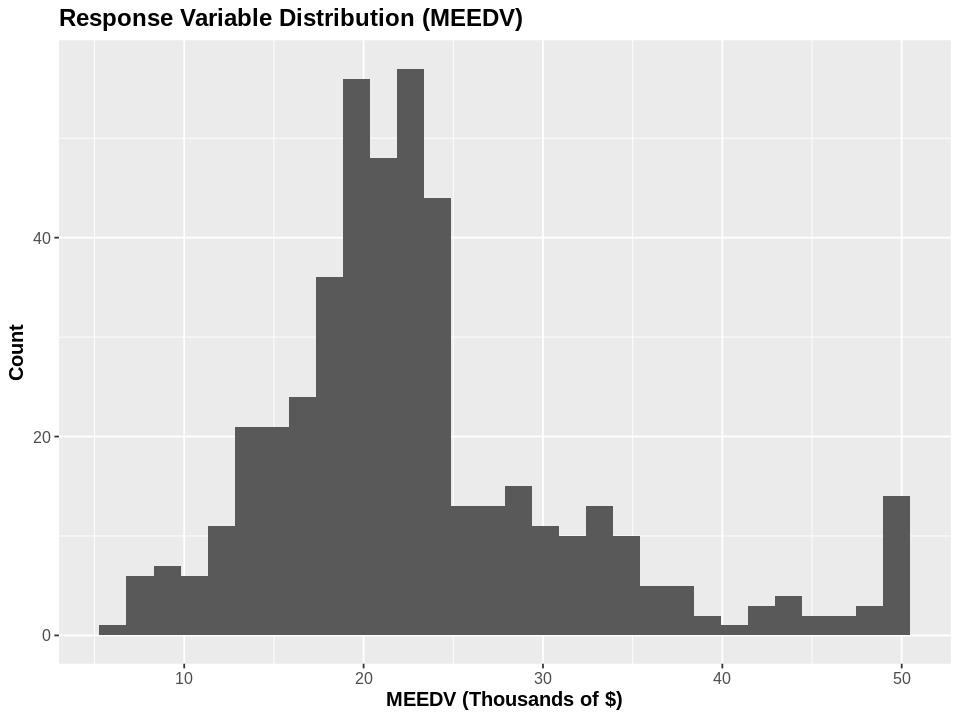

In [5]:
meedv_plot <- boston_data %>%
    ggplot() +
    geom_histogram(aes(MEEDV),bins=30) +
    labs(x="MEEDV (Thousands of $)",
         y="Count",
         title="Response Variable Distribution (MEEDV)") +
    theme(
        text = element_text(size = 12),
        plot.title = element_text(face = "bold"),
        axis.title = element_text(face = "bold")
    )
meedv_plot

#### 2.5. Summary of Statistics

In [6]:
summary(boston_data)

      CRIM                ZN            INDUS            CHAS        
 Min.   : 0.00632   Min.   : 0.00   Min.   : 0.00   Min.   :0.00000  
 1st Qu.: 0.08221   1st Qu.: 0.00   1st Qu.: 5.19   1st Qu.:0.00000  
 Median : 0.25915   Median : 0.00   Median : 9.69   Median :0.00000  
 Mean   : 3.62065   Mean   :11.17   Mean   :11.13   Mean   :0.06998  
 3rd Qu.: 3.67822   3rd Qu.:12.50   3rd Qu.:18.10   3rd Qu.:0.00000  
 Max.   :88.97620   Max.   :95.00   Max.   :27.74   Max.   :1.00000  
 NA's   :1                                                           
      NOX               RM              AGE              DIS        
 Min.   :0.3850   Min.   : 3.561   Min.   : 1.137   Min.   : 1.130  
 1st Qu.:0.4490   1st Qu.: 5.925   1st Qu.:33.500   1st Qu.: 2.358  
 Median :0.5380   Median : 6.229   Median :68.200   Median : 3.671  
 Mean   :0.5674   Mean   : 6.413   Mean   :60.507   Mean   : 5.072  
 3rd Qu.:0.6240   3rd Qu.: 6.638   3rd Qu.:90.000   3rd Qu.: 5.500  
 Max.   :6.8160   Max.   :

## 3. Methods: Plan

This dataset was collected by the US Census Service in the area of Boston. As this data is used for government programs and communities within Boston. Since this dataset was collected through a government agency we can see the legitimacy and the trustworthiness of it. 

We will be using either simple linear regression or multi-regression to try and fit the data. We will compare our predictive models with F-test and anova test as the model we implement may be nested. Furthermore, we will be validating our prediction through methods such as the cross-validated prediction error, cp, and backward selection. 

Overall, we would be trying to predict the median housing price of the Boston housing based on the inclusion of different variables in the dataset such as crime per capita, number of railways, etc. In the end, we would want to find out which variables affect the price the most and which variables are the least correlated through cross-validation and comparing the coefficient of determination. Our group believes that crime rate will be the most influential dataset. The impact of our prediction will show how these prices are determined and we can compare it with our initial hypothesis and also we can find any outliers that show causation.


#### Conclusion

We expect to find the most optimal model that predicts median housing price with the use of the best model with several explanatory variables available. Our results could help people in making a more conscious decision when trying to find their perfect homes. They could factor out what conditions they need for a perfect home and find out the best value for such a house


## 4. References

Boston Housing Market: House Prices &amp; Trends | Redfin. (n.d.). Retrieved November 4, 2022, from https://www.redfin.com/city/1826/MA/Boston/housing-market 

Vishal, V. (2017, October 27). Boston Housing Dataset. Kaggle. Retrieved November 3, 2022, from https://www.kaggle.com/datasets/altavish/boston-housing-dataset 